In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns 
from pathlib import Path
from math import isnan, ceil

import matplotlib.pyplot as plt

from graphframes import *

########## START - PYSPARK ##########
from pyspark import SparkContext, SparkConf

from pyspark.sql import SparkSession, SQLContext, Row
from pyspark.sql.types import *
from pyspark.sql.window import Window
from pyspark.sql.functions import col, expr, count, to_timestamp, monotonically_increasing_id, \
    desc, sum as _sum, min, max, rand, when, \
    datediff, dayofmonth, weekofyear, month, year, hour, dayofweek, \
    unix_timestamp, array, lit, round as _round

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer 
########## END - PYSPARK ##########

spark = SparkSession.builder \
    .appName("AMD-SM2L Joint Project") \
    .config("spark.driver.memory", "3g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .master("local[*]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("OFF")
dataframe = spark.read.parquet("src/datasets/small_with_ids.parquet", header=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/24 19:33:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Feature computing

dato il dataset iniziale: 
- calcolo le feature indipendenti nel dataset completo
- divido il df in train e test
- calcolo le feature dipendenti
- aggiorno train e test

In [2]:
class FeatureManager:
    def __init__(self, dataframe):
        # Percorso del file Parquet
        self.origDF = dataframe
        
    def compute_features_of_whole_df(self):
        path = 'src/datasets/small_features.parquet'
        if not Path(path).exists():
            self.df_features = self.origDF\
                .withColumnRenamed('receiving_currency', 'rec_cur')\
                .withColumnRenamed('payment_currency', 'pay_cur')\
                .withColumnRenamed('payment_format', 'pay_for')\

            currencies = self.df_features.select('rec_cur').distinct().union(self.df_features.select('pay_cur').distinct())
            
            currency = StringIndexer(inputCol='rec_cur', outputCol='receiving_currency')
            payment_format = StringIndexer(inputCol='pay_for', outputCol='payment_format')
            
            rec_currency_model = currency.fit(currencies)
            self.df_features = rec_currency_model.transform(self.df_features)
            pay_currency_model = rec_currency_model.setInputCol('pay_cur').setOutputCol('payment_currency')
            self.df_features = pay_currency_model.transform(self.df_features)
            
            payment_format_model = payment_format.fit(self.df_features)
            self.df_features = payment_format_model.transform(self.df_features)
            self.ach_mapping = {v: k for k, v in dict(enumerate(payment_format_model.labels)).items()}
            
            column_order = ['id', 'timestamp',
                            'from_account','to_account','same_account',
                            'from_bank','to_bank','same_bank',
                            'amount_received','amount_paid','amount_difference','same_amounts',
                            'receiving_currency','payment_currency','same_currency',
                            'payment_format', 'is_laundering']
            
            self.df_features = self.df_features\
                    .withColumn('same_bank', (col('from_bank')==col('to_bank')).cast('integer'))\
                    .withColumn('same_account', (col('from_account')==col('to_account')).cast('integer'))\
                    .withColumn('same_currency', (col('receiving_currency')==col('payment_currency')).cast('integer'))\
                    .withColumn('same_amounts', (col('amount_received')==col('amount_paid')).cast('integer'))\
                    .withColumn('amount_difference', (col('amount_paid')-col('amount_received')))\
                    .select(column_order)

            self.df_features.write.parquet(path)
        else:
            self.df_features = spark.read.parquet(path, header=True)

    def compute_timestamp_features(self, df_type=0): # df_type = 0 (train), 1 (test), 2 (validation)
        if df_type==0:
            df = self.train_df 
        elif df_type==1:
            df = self.test_df
        # else:
        #     df = self.validation_df

        df = df\
            .withColumn('week', weekofyear("timestamp"))\
            .withColumn('day_of_month', dayofmonth("timestamp"))\
            .withColumn('day_of_week', dayofweek("timestamp"))\
            .withColumn('hour', hour("timestamp"))

        hour_FA = df.groupBy('from_account','hour').agg(count('*').alias('transactions_same_hour_fa'))
        day_of_month_FA = df.groupBy('from_account','day_of_month').agg(count('*').alias('transactions_same_day_fa'))
        week_FA = df.groupBy('from_account','week').agg(count('*').alias('transactions_same_week_fa'))
        
        hour_FA_TA = df.groupBy('from_account','to_account', 'hour').agg(count('*').alias('transactions_same_hour_fata'))
        day_of_month_FA_TA = df.groupBy('from_account','to_account','day_of_month').agg(count('*').alias('transactions_same_day_fata'))
        week_FA_TA = df.groupBy('from_account','to_account','week').agg(count('*').alias('transactions_same_week_fata'))
        
        df = df\
            .join(hour_FA, ['from_account', 'hour'], 'left')\
            .join(day_of_month_FA, ['from_account', 'day_of_month'], 'left')\
            .join(week_FA, ['from_account', 'week'], 'left')\
            .join(hour_FA_TA, ['from_account', 'to_account', 'hour'], 'left')\
            .join(day_of_month_FA_TA, ['from_account', 'to_account', 'day_of_month'], 'left')\
            .join(week_FA_TA, ['from_account', 'to_account', 'week'], 'left')
        
        columns = df.columns
        columns.remove('id')
        columns.insert(0, 'id')
        columns.remove('is_laundering')
        columns.append('is_laundering')
        
        df = df.select(columns)
        
        if df_type==0:
            self.train_df = df
        elif df_type==1:
            self.test_df = df
        # else:
        #     self.validation_df = df

    def split_with_undersampling(self):
        self.df_features = self.df_features.drop('from_bank','to_bank')
        launderings = self.df_features.filter('is_laundering==1')
        non_launderings = self.df_features.filter('is_laundering==0')
        
        train_l, test_l, validation_l = launderings.randomSplit([0.8, 0.2])#, 0.1])
        launderings_count = launderings.count()
        non_launderings_count = non_launderings.count()
        
        percentage_launderings = ceil(100*launderings_count/(launderings_count + non_launderings_count)) # 0.1%
        undersampling = launderings_count*90/10
        print(f'Laundering transactions are {percentage_launderings}% of the whole dataset ({launderings_count} transactions).\
                \nThe classes are unbalanced, so '+\
                f'the number of non laundering transaction will be reduced to {int(undersampling)}')
        
        sample_non_laundering = non_launderings.orderBy(rand()).limit(int(undersampling))
        train_nl, test_nl, validation_nl = sample_non_laundering.randomSplit([0.8, 0.2])#, 0.1])

        self.train_df = train_l.union(train_nl)
        self.test_df = test_l.union(test_nl)
        #self.validation_df = validation_l.union(validation_nl)
        
        self.train_df.select('id').join(self.origDF, 'id', 'left').write.parquet('src/datasets/train_orig_features.parquet')
        self.test_df.select('id').join(self.origDF, 'id', 'left').write.parquet('src/datasets/test_orig_features.parquet')
        #self.validation_df.select('id').join(self.origDF, 'id', 'left').write.parquet('src/datasets/validation_orig_features.parquet')

    def save_dataframes(self, path):
        self.train_df.write.parquet(path.format('train_set'))
        self.test_df.write.parquet(path.format('test_set'))
        self.validation_df.write.parquet(path.format('validation_set'))
        

## Whole dataset features

In [3]:
manager = FeatureManager(dataframe)
manager.compute_features_of_whole_df()
manager.split_with_undersampling()

Laundering transactions are 1% of the whole dataset (5177 transactions).                
The classes are unbalanced, so the number of non laundering transaction will be reduced to 46593


## Split and computation over train, test & validation

In [4]:
manager.compute_timestamp_features(df_type=0)
manager.compute_timestamp_features(df_type=1)
#manager.compute_timestamp_features(df_type=2)
manager.save_dataframes('src/datasets/{}_noGF.parquet')

### Correlation Matrix

In [10]:
def correlation_matrix(df):     
    columns = df.columns
    assembler = VectorAssembler(inputCols=columns, outputCol="features")
    feature_vector = assembler.transform(df)

    matrix = Correlation.corr(feature_vector, "features").collect()[0][0]
    corr_matrix = np.array(matrix.toArray())

    plt.figure(figsize=(20, 10))
    sns.heatmap(corr_matrix, xticklabels=columns, yticklabels=columns)

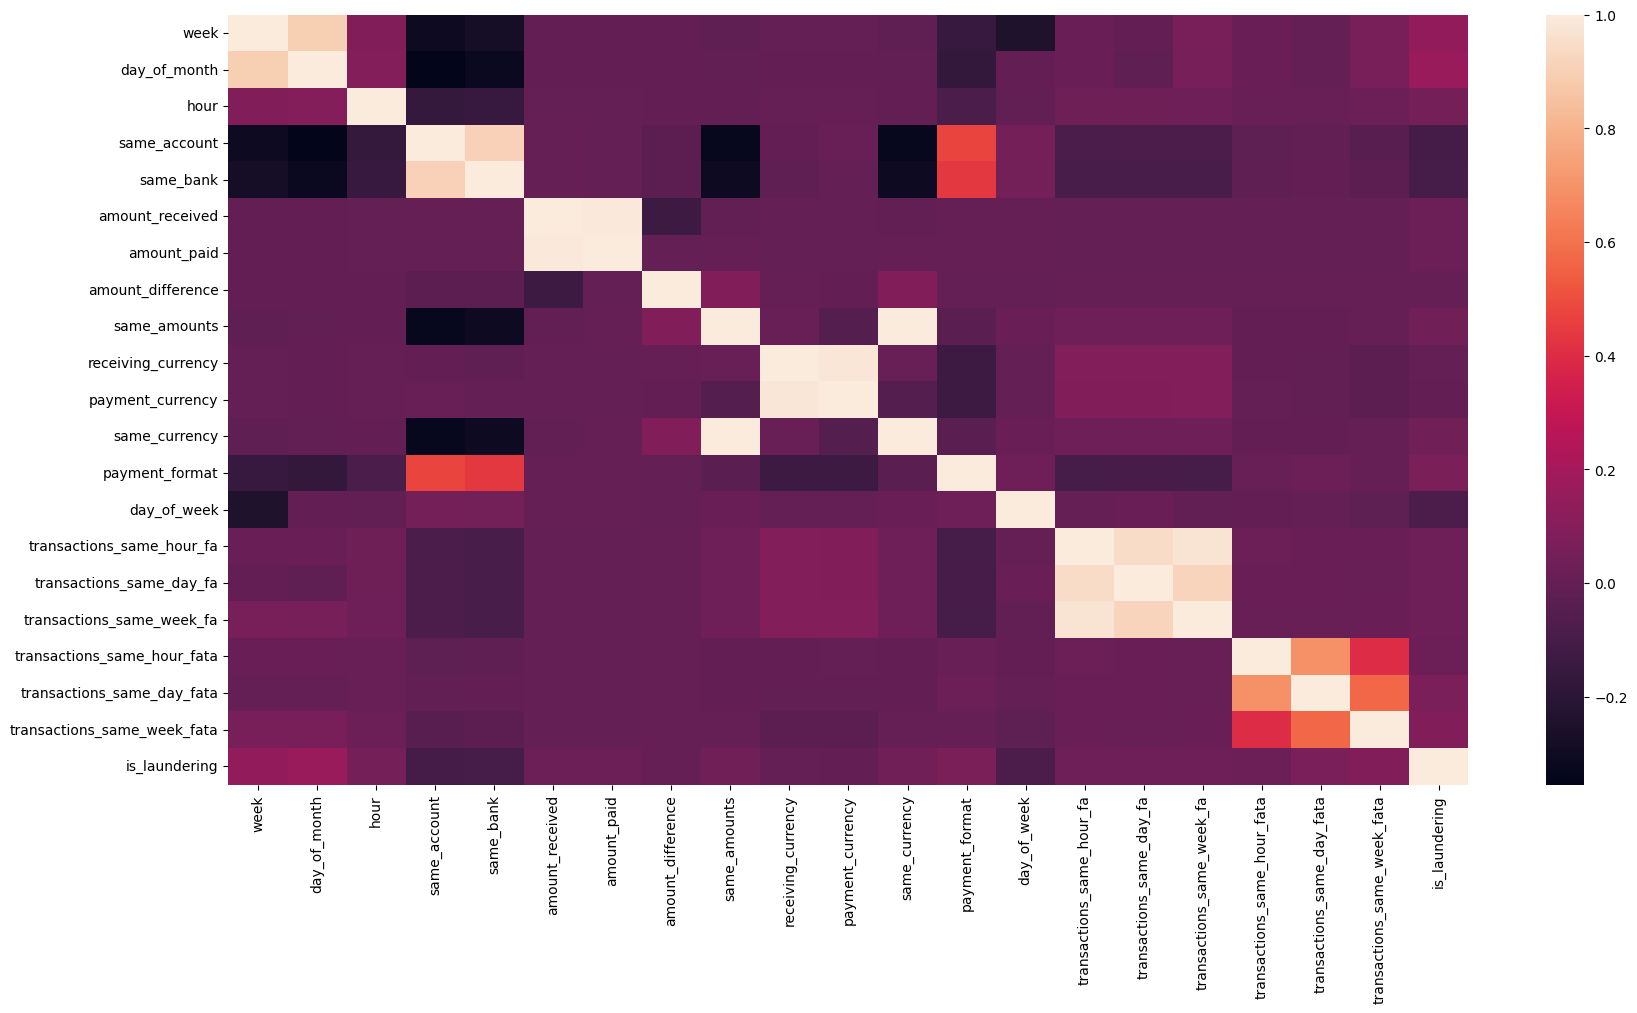

In [6]:
train_corr = manager.train_df.drop('id', 'from_account','to_account','timestamp')
correlation_matrix(train_corr)

come possiamo vedere ci sono alcune feature che sono veramente inutili, come amount_paid, received, hour etc. 
Possiamo però vedere se sono utili per il calcolo di altre feauture

## Graphframes

The next step is to understand the structure of the different patterns in order to identify further features


<img src="src/images/patterns.png" style="width: 600px">


In order to do that, I thought that the best solution was to process the dataset using GraphFrames, a package for Apache Spark which provides DataFrame-based Graph.

Looking at the image below, it would be beneficial to process certain features for each node in the graph to gain valuable insights into the transactions:
1. **Compute the number of in-out edges (fan-in, fan-out)** <br>
    A transaction involves an exchange between two accounts, and it would be valuable to calculate the connection degrees for each account:
    * In-out degrees for the sender account
    * In-out degrees for the receiver account
    <br><br>
2. **Identify intermediary transactions (scatter-gather)** <br>
    By analyzing the flow of transactions, we can identify intermediary transactions. These are transactions that act as intermediaries, facilitating the movement of funds between multiple accounts
    <br><br>
3. **Detect forwarding transactions** <br>
    An account receives a sum of money and then forwards it to another account
    <br><br>
4. **Check for intermediate transactions between two transactions** <br>
    We can check if certain transactions act as intermediaries between two other transactions
    <br><br>

____

In [2]:
train = spark.read.parquet('src/datasets/train_set_noGF.parquet')
test = spark.read.parquet('src/datasets/test_set_noGF.parquet')
#validation = spark.read.parquet('src/datasets/validation_set_noGF.parquet')

In [3]:
train_orig_features = train.select('id').join(dataframe, 'id', 'left')
test_orig_features = test.select('id').join(dataframe, 'id', 'left')
#validation_orig_features = validation.select('id').join(dataframe, 'id', 'left')

In [4]:
class MyGraph:
    # create the graph using the vertices and edges found in the dataset taken into account (train or test)
    def __init__(self, df):
        self.df = df
        self.ids = self.df.select('id','from_account','to_account')
        self.vertices, self.edges, self.g = self.create_graph()
        self.compute_inOut_degrees()

    def create_graph(self, init=True):
        vertices = self.df.select("from_account")\
                            .withColumnRenamed('from_account', 'id')\
                            .union(self.ids.select("to_account"))\
                            .distinct()
        if init:
            edges = self.df.withColumnRenamed('from_account', 'src')\
                .withColumnRenamed('to_account', 'dst')
        else:
            edges = self.df.withColumnRenamed('from_account', 'src')\
                .withColumnRenamed('to_account', 'dst').filter('from_account!=to_account and receiving_currency==payment_currency and payment_format="ACH"')\
                .select('id','timestamp','src','dst','payment_currency','payment_format')

        g = GraphFrame(vertices, edges)
        return vertices, edges, g

    def compute_inOut_degrees(self):
        # for each account, it computes the number of ingoing and outgoing transactions 
        vertexInDegrees = self.g.inDegrees
        vertexOutDegrees = self.g.outDegrees
        vertices = vertexInDegrees.join(vertexOutDegrees, 'id', 'fullouter').fillna(0)
        
        vertices = vertices.withColumnRenamed('id', 'from_account')
        self.ids = self.ids.alias('df').join(vertices.alias('vertices'), 'from_account', 'left')\
                        .withColumnRenamed('inDegree','from_account_inDegree')\
                        .withColumnRenamed('outDegree','from_account_outDegree')

        vertices = vertices.withColumnRenamed('from_account', 'to_account')
        self.ids = self.ids.join(vertices.alias('vertices'), 'to_account', 'left')\
                    .withColumnRenamed('inDegree','to_account_inDegree')\
                    .withColumnRenamed('outDegree','to_account_outDegree')

    def get_forwards(self):
        # it consists in getting all transactions in which the receiver of the transaction 
        # sends the same amount of received money to another account
        # OUTPUT: id of inolved transactions where:
        # - before_forward: 1 if a transaction is that one before a secondly forwarding transaction
        # - forward: 1 if a transaction is that one that makes the forward

        motif = "(a)-[e]->(b); (b)-[e2]->(c)"
        forwards = self.g.find(motif).filter("e.amount_received == e2.amount_paid and e.timestamp <= e2.timestamp and a!=b and b!=c")
    
        before_forward = forwards.select(col('e.id').alias('id'))\
            .distinct()\
            .withColumn('before_forward',lit(1))
        # distinct: I can use it, or I can count how many times the id is involved
        forward = forwards.select(col('e2.id').alias('id'))\
            .distinct()\
            .withColumn('forward',lit(1))
        # distinct: I can use it, or I can count how many times the id is involved
    
        self.forwards = before_forward.join(forward, 'id','left')#.na.fill(value=0,subset=['before_forward','forward'])
     
    def same_or_similar(self):
        # it search if for each transaction there is:
        # - another transaction with the same attributes, except the amounts (exists_same)
        # - another transaction with similar attributes, except the timestamps and amounts (exists_similar)
        motif = "(a)-[t1]->(b); (a)-[t2]->(b)"

        same_where = 't1.timestamp == t2.timestamp and \
                        t1.payment_currency == t2.payment_currency and \
                        t1.receiving_currency == t2.receiving_currency and \
                        t1.payment_format == t2.payment_format and \
                        t1.amount_paid != t2.amount_paid and \
                        t1.id != t2.id'
        
        self.same = self.g.find(motif).filter(same_where).select('t1.id').withColumn('exists_same',lit(1)).distinct()

        similar_where = 't1.timestamp != t2.timestamp and \
                        t1.payment_currency == t2.payment_currency and \
                        t1.receiving_currency == t2.receiving_currency and \
                        t1.payment_format == t2.payment_format and \
                        t1.amount_paid != t2.amount_paid'

        
        self.similar = self.g.find(motif).filter(similar_where).select('t1.id').withColumn('exists_similar',lit(1)).distinct()
########## START - FAN PATTERN ##########
    def compute_fan_in(self):
        """
            as explained in undestand_pattern.ipynb it is useful to compute the following feature: 
            - for each to_account, the number of incoming nodes to the same bank and all in node must have the same: 
                * receiving_currency 
                * payment_currency
                * payment_format
                * there must be at most 4 days between the first transaction and the last in the series
        """
        motif = "(a)-[t1]->(b); (c)-[t2]->(b)"
        
        fan_in_query = 'abs(datediff(t1.timestamp, t2.timestamp)) <= 4 and \
                    t1.payment_currency == t2.payment_currency and \
                    t1.receiving_currency == t2.receiving_currency and \
                    t1.payment_format == t2.payment_format'
                
        fan_in = self.g.find(motif).filter(fan_in_query).select('a', 'b', 't1')
        fan_in = fan_in.groupBy('a', 'b', 't1').count().select('t1.id',col('count').alias('fan_in_degree'))

        return fan_in

    def compute_fan_out(self):
        """
            as explained in undestand_pattern.ipynb it is useful to compute the following feature: 
            - for each from_account, the number of outgoing nodes to the same bank and all in node must have the same: 
                * payment_format
                * there must be at most 4 days between the first transaction and the last in the series
            
            in order to handle the big amount of data, data are firstly filtered:
            - self transaction (from_account == to_account) doesn't exist in the same fan-out
            - two similar transactions (t1(from_account, to_account) == t2(from_account, to_account) ) don't exist in the same fan-out 
            - fan-outs have ACH payment_format
        """
        _, _, g = self.create_graph(False)

        motif = "(a)-[t1]->(b); (a)-[t2]->(c)"
        
        fan_out_query = 'abs(datediff(t1.timestamp, t2.timestamp)) <= 4 and \
                        a != b and a != c and b != c and\
                        t1.id != t2.id'
                
        fan_out = g.find(motif).filter(fan_out_query).select('a', 'b', 'c', 't1.id')
        fan_out = fan_out.groupBy('a','b','c','id').count()
        fan_out = fan_out.groupBy('id').agg(count('*').alias('fan_out_degree')).select('id', 'fan_out_degree').withColumn('fan_out_degree', col('fan_out_degree')+1)
        
        return fan_out
    
    def compute_fan(self):
        fan_in = self.compute_fan_in()
        fan_out = self.compute_fan_out()  
        
        self.fans = fan_in.join(fan_out, 'id', 'fullouter')
########## END - FAN PATTERN ##########

########## START - CYCLE PATTERN ##########
    def generate_combinations(self,accounts):
        accounts = set(accounts)
        conditions = []
        for acc in accounts: 
            for acc2 in accounts:
                if acc!=acc2:
                    if ((acc, acc2) not in conditions) and ((acc2, acc) not in conditions):
                        conditions.append((acc,acc2))

        return ' and '.join(conditions[k][0]+'!='+conditions[k][1] for k in range(len(conditions)))

    def build_rules_of_cycles(self, max_iter):
        alphabet = list(map(chr, range(97, 123)))
        start = 2

        rules = []
        
        for i in range(start-1, max_iter+1):
            full_rule = []
            single_query = []
            transactions = []
            receiving_accounts = []
            select = []
            accounts = []
            for j in range(0, i+1):
                receiving_account = alphabet[j+1] if j < i else alphabet[0]
                receiving_accounts.append(receiving_account)

                single_transaction = 't{}'.format(j+1)
                transactions.append(single_transaction)

                starting_account = alphabet[j]

                single_rule = "({})-[{}]->({})".format(starting_account, single_transaction, receiving_account)
                accounts.append(starting_account)
                accounts.append(receiving_account)

                full_rule.append(single_rule)    
                select.append(single_transaction)
            
            single_query.append(' and '.join(transactions[k] + '.timestamp <= ' + transactions[k+1] + '.timestamp' for k in range(len(transactions) - 1)))
            single_query.append(self.generate_combinations(accounts))
        
            rules.append(('; '.join(full_rule), ' and '.join(single_query), select, (i+1)))

        return rules

    def find_cycles(self, max_iter):
        # this method obtains 3 features: 
        # - min_cycle: != 0 if the transaction is the starting one of a cycle
        # - max_cycle: != 0 if the transaction is the starting one of a cycle (== min_cycle if there's only that kind of degree)
        # - involved: 1 if the transaction is involved in a cycle, 0 otherwise
        _, _, g = self.create_graph(False)
        
        created_df = False

        max_iter = 1 if (max_iter-2) < 1 else max_iter-1
        rules = self.build_rules_of_cycles(max_iter)
        
        for rule in rules: 
            motif, query, select, degree = rule
            degree_cycle = g.find(motif).filter(query)
            
            for sel in range(len(select)): 
                if sel==0:
                    new_col = 'start'
                    select_id = '{}.id'.format(select[sel])
                else:
                    new_col = 't{}_id'.format(sel+1)
                    select_id = '{}.id'.format(select[sel])

                select[sel] = select_id
                degree_cycle = degree_cycle.select(select).withColumnRenamed('id', new_col)
                select[sel] = new_col

            degree_cycle_start = degree_cycle.select('start').distinct().withColumnRenamed('start', 'id')
            degree_cycle_involved = degree_cycle.drop('start')
            degree_cycle_involved = degree_cycle_involved.select(array([col(column) for column in degree_cycle_involved.columns])\
                                               .alias('id')).selectExpr('explode(id) as id').distinct()

            startings = self.in_cycle(degree_cycle_start, degree) # != 0 if a transaction is the starting one of a cycle
            print("adding cycles of degree {}...".format(degree))
            if not created_df: 
                starting_cycles = startings
                intermediaries_cycles = degree_cycle_involved
                created_df = True
            else:
                starting_cycles = starting_cycles.union(startings)
                intermediaries_cycles = intermediaries_cycles.union(degree_cycle_involved)

        starting_cycles = starting_cycles.groupBy('id').agg(
            min("min_cycle").alias("min_cycle"),
            max("max_cycle").alias("max_cycle")
        )
        
        intermediaries_cycles = intermediaries_cycles.distinct()
        
        self.cycles = starting_cycles.join(intermediaries_cycles, 'id','fullouter').withColumn('involved', lit(1))
            
    def in_cycle(self, cycle_subset, degree):
        cycle_subset = cycle_subset\
            .withColumn('min_cycle', lit(degree))\
            .withColumn('max_cycle', lit(degree))
                
        return cycle_subset        
    
########## END - CYCLE PATTERN ########## 
    def page_rank(self):
        res = self.g.pageRank(resetProbability=0.15, tol=0.1) 
        edges = res.edges.select('src','dst','weight','id')\
            .withColumnRenamed('src','from_account').withColumnRenamed('dst','to_account')\
            .withColumn('weight_t', _round(col('weight'),2))\
            .drop('weight')

        vertices = res.vertices.withColumn('page_rank', _round(col('pagerank'),2)).select('id','page_rank').withColumnRenamed('id','from_account')
        edges = vertices.join(edges, 'from_account', 'right').withColumnRenamed('page_rank','fa_pagerank')
        vertices = vertices.withColumnRenamed('from_account', 'to_account')
        edges = vertices.join(edges, 'to_account', 'right').withColumnRenamed('page_rank','ta_pagerank')\
            .select('id','fa_pagerank','ta_pagerank','weight_t')

        self.ids = self.ids.join(edges, 'id', 'left')

    def join_features(self):
        self.ids = self.ids.drop('from_account','to_account')
        self.ids = self.ids.join(self.forwards, 'id','left')
        self.ids = self.ids.join(self.similar, 'id', 'left').join(self.same, 'id', 'left')
        self.ids = self.ids.join(self.fans, 'id','left')

        self.df = self.df.join(self.ids, 'id', 'left').na.fill(value=0,subset=['exists_similar','forward','before_forward','exists_same']).na.fill(value=1,subset=['fan_out_degree', 'fan_in_degree'])

    def final_permutation_and_save(self, df_, df_type=0):
        self.df = self.df.drop('from_bank','from_account','timestamp','to_bank','to_account',\
            'receiving_currency','payment_currency','payment_format','is_laundering',\
            'amount_paid','amount_received')
        
        df_ = df_.drop('from_account','to_account','timestamp')
        self.df = self.df.join(df_, 'id', 'left')

        if df_type==0:
            file_name = 'train'
        elif df_type==1:
            file_name = 'test'
        else:
            file_name = 'validation'

        self.df.write.parquet('src/datasets/{}_set_withGF.parquet'.format(file_name))

In [ ]:
def batch_graph(set_orig_features, set_no_GF, df_type=0):
    obj = MyGraph(train_orig_features)
    obj.get_forwards()
    obj.same_or_similar()
    obj.compute_fan()
    obj.page_rank()
    obj.ids = obj.ids.cache()
    obj.join_features() 
    obj.final_permutation_and_save(set_no_GF, df_type)
    obj.ids.unpersist()

In [ ]:
batch_graph(train_orig_features, train, df_type=0)
batch_graph(test_orig_features, test, df_type=1)

In [ ]:
train_graph = MyGraph(train_orig_features)
train_graph.get_forwards()
train_graph.same_or_similar()
train_graph.compute_fan()
train_graph.page_rank()
train_graph.ids = train_graph.ids.cache()
train_graph.join_features() 
train_graph.final_permutation_and_save(train)
train_graph.ids.unpersist()

In [ ]:
to_be_removed = ['from_account_outDegree', 'to_account_outDegree', 'forward', 'exists_same', 'hour', 'same_account',
                 'same_bank', 'amount_received','amount_paid', 'amount_difference']

In [ ]:
test_graph = MyGraph(test_orig_features)
test_graph.get_forwards()
test_graph.same_or_similar()
test_graph.compute_fan()
test_graph.page_rank()
test_graph.ids = test_graph.ids.cache()
test_graph.join_features() 
test_graph.final_permutation_and_save(test, 1)
test_graph.ids.unpersist()

# Feature selection

In [8]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.preprocessing import StandardScaler

train = spark.read.parquet('src/datasets/train_set_withGF.parquet')
X_train, y_train = train.drop('id','is_laundering'), train.select('is_laundering')

X_train_pd = X_train.toPandas()
y_train_pd = y_train.toPandas()

test = spark.read.parquet('src/datasets/test_set_withGF.parquet')
X_test, y_test = test.drop('id','is_laundering'), test.select('is_laundering')

X_test_pd = X_test.toPandas()
y_test_pd = y_test.toPandas()

validation = spark.read.parquet('src/datasets/validation_set_withGF.parquet')

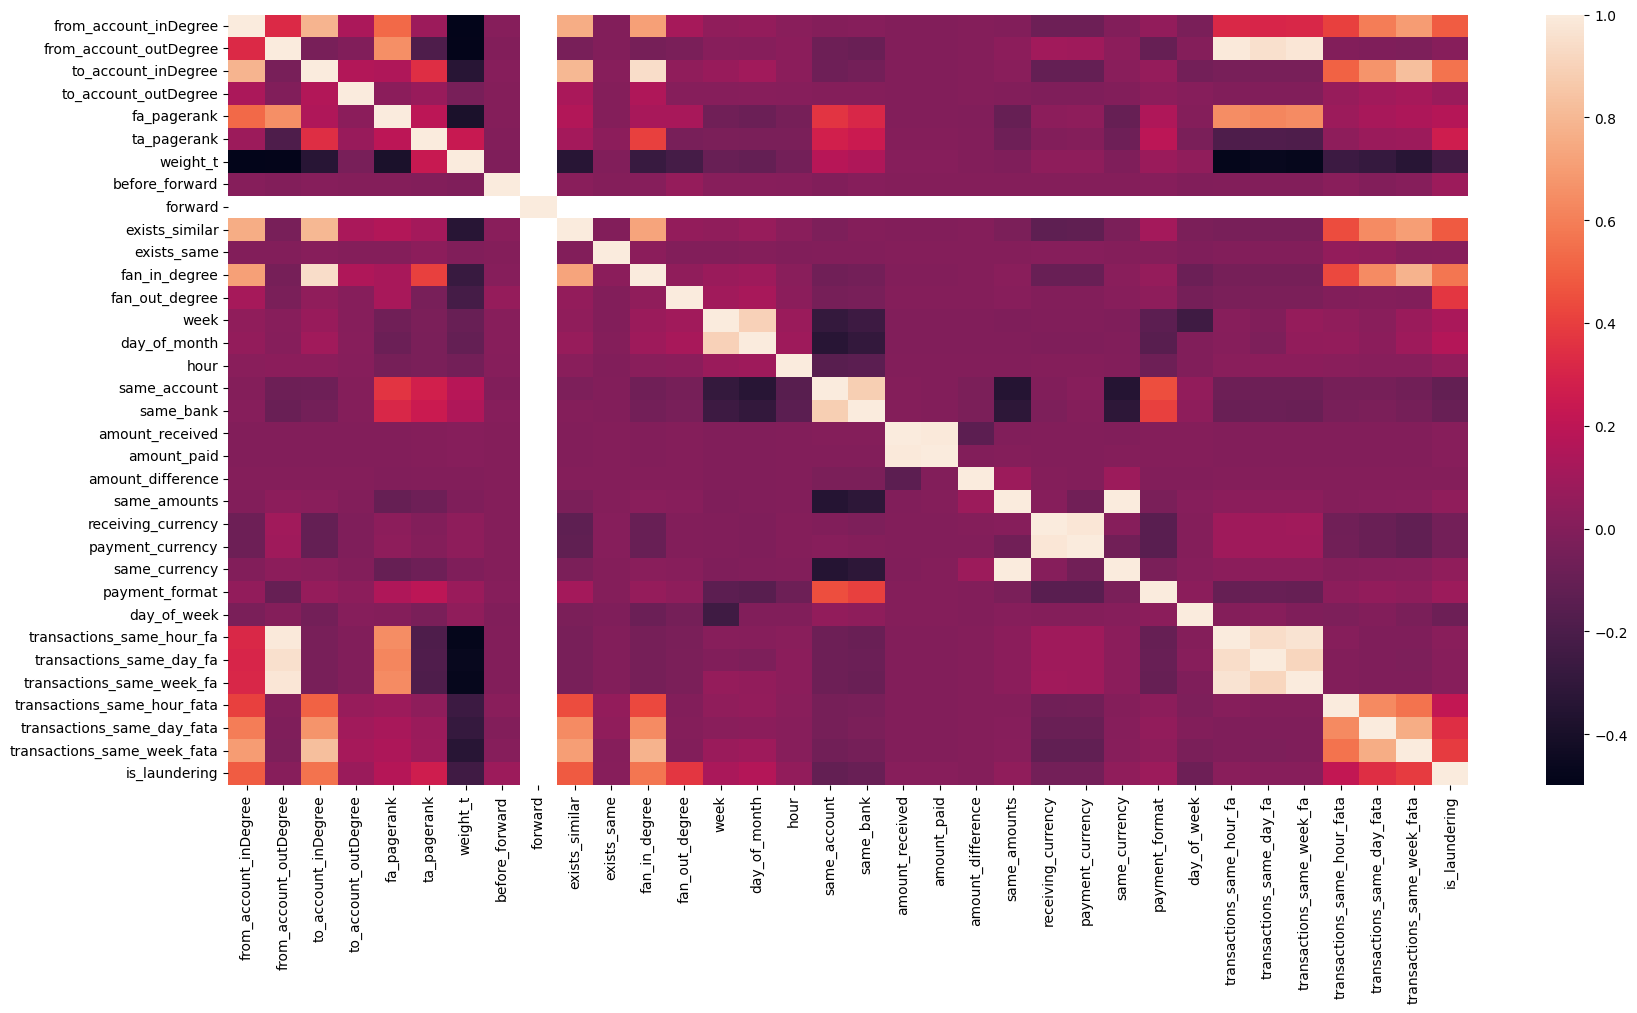

In [11]:
correlation_matrix(train.drop('id'))

## Lasso Regression

Approccio di regressione logistica seguito dal sito

https://vishaljadhav96.medium.com/feature-selection-with-lasso-regression-645308c78b5b

Effettuando lo scaling delle features l'algoritmo converge più velocemente e toglie anche il rischio di non convergere

In [12]:
from sklearn.preprocessing import StandardScaler

cols = X_train.columns 
no_scale = ['before_forward', 'forward','exists_similar','exists_same',
                     'same_account', 'same_bank','amount_received','amount_paid','amount_difference']

cols_to_scale = [col for col in cols if col not in no_scale]

# operazione di normalizzazione necessaria prima di applicare il modello
scaler = StandardScaler()
X_train_pd[cols_to_scale] = scaler.fit_transform(X_train_pd[cols_to_scale])
X_test_pd[cols_to_scale] = scaler.fit_transform(X_test_pd[cols_to_scale])

Effettuando lo scaling di tutte le feature, con il codice sottostante, l'algoritmo converge ancor più velocemente

In [13]:
from sklearn.preprocessing import StandardScaler

# operazione di normalizzazione necessaria prima di applicare il modello
scaler = StandardScaler()
X_train_pd[X_train_pd.columns] = scaler.fit_transform(X_train_pd[X_train_pd.columns])
X_test_pd[X_test_pd.columns] = scaler.fit_transform(X_test_pd[X_test_pd.columns])

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#Listing all values I want to try as C value
C=[1,0.75,0.50, 0.25, 0.1, 0.05, 0.025, 0.01, 0.005, 0.0025]
#Intiate Metric of zeros with 6 columns and rows equal to len(C)
l1_metrics = np.zeros((len(C),6))
#Adding first column as value C
l1_metrics[:,0]=C

y_train_pd_r = y_train_pd.values.ravel()
y_test_pd_r = y_test_pd.values.ravel()

# Run a for loop over the range of C list length
for index in range(0, len(C)):
    # Initialize and fit Logistic Regression with the C candidate
    logreg = LogisticRegression(penalty='l1', C=C[index], solver='liblinear')
    logreg.fit(X_train_pd, y_train_pd_r)
    # Predict on the testing data
    y_pred_pd = logreg.predict(X_test_pd)
    # Create non-zero count and all metrics columns
    l1_metrics[index,1] = np.count_nonzero(logreg.coef_)
    l1_metrics[index,2] = accuracy_score(y_test_pd_r, y_pred_pd)
    l1_metrics[index,3] = precision_score(y_test_pd_r, y_pred_pd)
    l1_metrics[index,4] = recall_score(y_test_pd_r, y_pred_pd)
    l1_metrics[index,5] = f1_score(y_test_pd_r, y_pred_pd)

col_names = ['C','Non-Zero Coeffs','Accuracy','Precision','Recall','F1_score']
pd.DataFrame(l1_metrics, columns=col_names)

,C,Non-Zero Coeffs,Accuracy,Precision,Recall,F1_score
0,1.0000,30.0,0.922905,0.789272,0.363958,0.498186
1,0.7500,30.0,0.922905,0.789272,0.363958,0.498186
2,0.5000,30.0,0.922905,0.789272,0.363958,0.498186
3,0.2500,28.0,0.923277,0.790875,0.367491,0.501809
4,0.1000,25.0,0.922720,0.781955,0.367491,0.500000
5,0.0500,24.0,0.923091,0.787879,0.367491,0.501205
6,0.0250,21.0,0.924392,0.819277,0.360424,0.500613
7,0.0100,20.0,0.919376,0.751908,0.348057,0.475845
8,0.0050,16.0,0.919376,0.751908,0.348057,0.475845
9,0.0025,11.0,0.919376,0.759843,0.340989,0.470732


Typically we would like to choose a model with reduced complexity that still maintains similar performance metrics.


In [15]:
#fiting Logistic Regression with C 0.1
logreg = LogisticRegression(penalty='l1', C=0.0050, solver='liblinear')
logreg.fit(X_train_pd, y_train_pd)
#We can call logreg.coef_ to get all coefficients
#Lets use this to create data frame with Feature name & coefficient
coef_df=pd.DataFrame(logreg.coef_,columns=X_train_pd.columns).T.reset_index()
coef_df.columns=["Feature","Coef"]
#Filter features with non zero coefficients and sort by coef value
coef_df_final=coef_df[coef_df["Coef"]!=0].sort_values(by="Coef").reset_index(drop=True)
#Lets print feature and its importance 
print(coef_df_final)

                  Feature      Coef
0            same_account -0.556584
1               same_bank -0.062944
2             day_of_week -0.045420
3    to_account_outDegree -0.000400
4             amount_paid  0.012969
5                    hour  0.014366
6                weight_t  0.089819
7          before_forward  0.112362
8             ta_pagerank  0.124926
9             fa_pagerank  0.130800
10           day_of_month  0.178282
11         exists_similar  0.190324
12         payment_format  0.237044
13  from_account_inDegree  0.485169
14         fan_out_degree  1.018005
15          fan_in_degree  1.299392


/Users/simonemalesardi/opt/anaconda3/envs/amd_sm2l/lib/python3.8/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
reduced_features = ['id'] + coef_df_final['Feature'].tolist() + ['is_laundering']

In [ ]:
reduced_features.remove('id')
reduced_features.remove('amount_paid')
reduced_features.remove('amount_received')

In [18]:
train.select(reduced_features).write.parquet('src/datasets/reduced_train_C.0050.parquet')
test.select(reduced_features).write.parquet('src/datasets/reduced_test_C.0050.parquet')
validation.select(reduced_features).write.parquet('src/datasets/reduced_validation_C.0050.parquet')

# Test DT

In [19]:
reduced_train = spark.read.parquet('src/datasets/reduced_train_C.0050.parquet')
reduced_test = spark.read.parquet('src/datasets/reduced_test_C.0050.parquet')

In [20]:
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.classification import DecisionTreeClassifier

inputCols = reduced_train.drop('is_laundering','id').columns
 
assembler = VectorAssembler(inputCols=inputCols, outputCol="features")
vectorized_train = assembler.transform(reduced_train)
vectorized_test = assembler.transform(reduced_test)

dt_classifier = DecisionTreeClassifier(labelCol="is_laundering", featuresCol="features")
model = dt_classifier.fit(vectorized_train)

predictions = model.transform(vectorized_test)
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="is_laundering", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.92
